In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
import scipy.sparse as sparse
import string
import gc

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing 

from sklearn.model_selection import GridSearchCV
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

In [2]:
train = pd.read_csv('train/train.csv')

In [3]:
train.head()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfider...,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipp...,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exe...,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-bi...,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-...,news


In [4]:
html = pd.read_csv('cleaned_html2.csv',encoding='utf-8')

In [5]:
html.head()

,Webpage_id,web_text
0,1,Skip to main content Twitter LinkedIn Search ...
1,2,Skip to main content Twitter LinkedIn Search ...
2,3,Skip to main content Twitter LinkedIn Search ...
3,4,Skip to main content Twitter LinkedIn Search ...
4,5,Skip to main content Twitter LinkedIn Search ...


In [6]:
print (len(train),len(html))

(53447, 79455)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53447 entries, 0 to 53446
Data columns (total 4 columns):
Webpage_id    53447 non-null int64
Domain        53447 non-null object
Url           53447 non-null object
Tag           53447 non-null object
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


In [8]:
html.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79455 entries, 0 to 79454
Data columns (total 2 columns):
Webpage_id    79455 non-null object
web_text      79331 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


In [9]:
train.isnull().sum()

Webpage_id    0
Domain        0
Url           0
Tag           0
dtype: int64

In [10]:
html.isnull().sum()

Webpage_id      0
web_text      124
dtype: int64

In [11]:
html = html.dropna()

In [12]:
len(html)

79331

In [13]:
html['Webpage_id'] = html['Webpage_id'].astype(int)

In [14]:
train = train.merge(html,on = 'Webpage_id',how='left')

In [15]:
len(train)

53447

In [16]:
train.isnull().sum()

Webpage_id    0
Domain        0
Url           0
Tag           0
web_text      8
dtype: int64

In [17]:
train = train.dropna()

In [18]:
train.head()

,Webpage_id,Domain,Url,Tag,web_text
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfider...,news,Skip to main content Twitter LinkedIn Search ...
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipp...,news,Skip to main content Twitter LinkedIn Search ...
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exe...,news,Skip to main content Twitter LinkedIn Search ...
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-bi...,news,Skip to main content Twitter LinkedIn Search ...
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-...,news,Skip to main content Twitter LinkedIn Search ...


In [19]:
train['url_clean'] = train.apply(lambda x: str(x['Url']).replace(x['Domain'],''),axis=1)

In [20]:
del train['Domain']

In [21]:
train.head()

,Webpage_id,Url,Tag,web_text,url_clean
0,1,http://www.fiercepharma.com/marketing/tecfider...,news,Skip to main content Twitter LinkedIn Search ...,http:///marketing/tecfidera-gilenya-and-aubagi...
1,2,http://www.fiercepharma.com/pharma/novo-equipp...,news,Skip to main content Twitter LinkedIn Search ...,http:///pharma/novo-equipped-to-weather-storm-...
2,3,http://www.fiercepharma.com/pharma/another-exe...,news,Skip to main content Twitter LinkedIn Search ...,http:///pharma/another-exec-departs-troubled-e...
3,4,http://www.fiercepharma.com/pharma/teva-buy-bi...,news,Skip to main content Twitter LinkedIn Search ...,http:///pharma/teva-buy-biosim-specialist-cell...
4,5,http://www.fiercepharma.com/marketing/actress-...,news,Skip to main content Twitter LinkedIn Search ...,http:///marketing/actress-marissa-tomei-partne...


In [22]:
import re
train['url_clean'] = train['url_clean'].apply(lambda x: (re.split('http:///|/|-',x))[1:])

In [23]:
train['url_length'] = train['url_clean'].apply(lambda x: len(x))

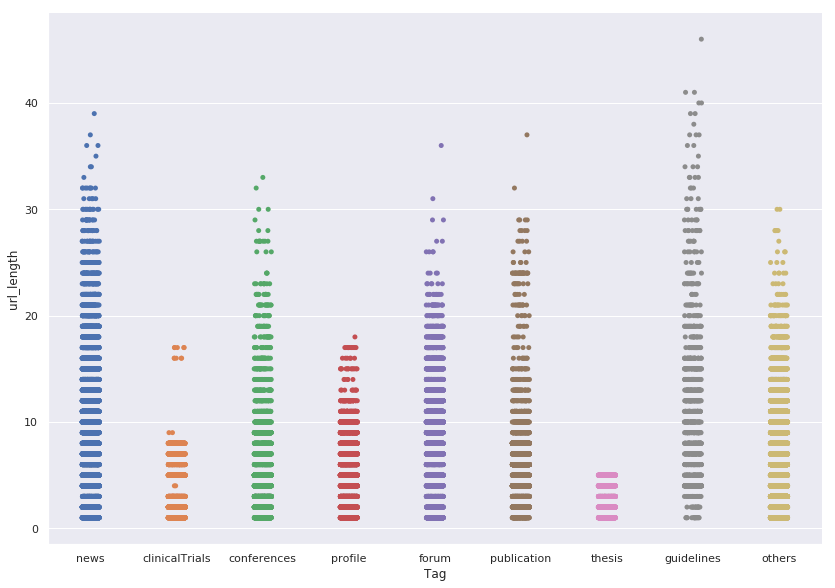

In [24]:
sns.catplot(x="Tag", y="url_length", data=train,height=8.27, aspect=11.7/8.27)

In [25]:
train['url_text'] = train['url_clean'].apply(lambda x: ' '.join(x))

In [26]:
del train['Url']
del train['url_clean']

In [27]:
train.head()

,Webpage_id,Tag,web_text,url_length,url_text
0,1,news,Skip to main content Twitter LinkedIn Search ...,17,marketing tecfidera gilenya and aubagio s 3 wa...
1,2,news,Skip to main content Twitter LinkedIn Search ...,12,pharma novo equipped to weather storm u s diab...
2,3,news,Skip to main content Twitter LinkedIn Search ...,13,pharma another exec departs troubled endo and ...
3,4,news,Skip to main content Twitter LinkedIn Search ...,11,pharma teva buy biosim specialist celltrion it...
4,5,news,Skip to main content Twitter LinkedIn Search ...,12,marketing actress marissa tomei partners aller...


In [28]:
vect_word = TfidfVectorizer(max_features=1000, analyzer='word', stop_words='english', ngram_range=(1,2), dtype=np.float32) 
vect_word.fit(train.url_text) 
tr_vect = vect_word.transform(train.url_text) 

In [29]:
vect_web = TfidfVectorizer(max_features=5000, analyzer='word', stop_words='english', ngram_range=(1,2), dtype=np.float32) 
vect_web.fit(train.web_text) 
tr_vect_web = vect_web.transform(train.web_text) 

In [30]:
std = RobustScaler()

In [31]:
le = preprocessing.LabelEncoder()
le.fit(train['Tag'].astype(str))
train['Tag'] = le.transform(train['Tag'].astype(str))

In [32]:
Y = train['Tag']
train = train[['url_length']]

In [33]:
train = pd.DataFrame(std.fit_transform(train)).set_index(train.index)


# train_features = hstack([tr_vect], 'csr')
train_features = hstack([tr_vect,tr_vect_web, csr_matrix(train.loc[train.index,])], 'csr')


In [35]:
model1 = XGBClassifier()
# model = LogisticRegression()
model1.fit(train_features,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [36]:
y_pred_train_xgb = model1.predict(train_features)

/home/shwetm/dl/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [37]:
accuracy = accuracy_score(Y, y_pred_train_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.64%


In [38]:
f1_score(Y, y_pred_train_xgb, average='weighted')  

0.9462692332107484

In [39]:
# model1 = XGBClassifier()
model2 = LogisticRegression()
model2.fit(train_features,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
y_pred_train_log = model2.predict(train_features)

In [41]:
accuracy = accuracy_score(Y, y_pred_train_log)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.46%


In [42]:
f1_score(Y, y_pred_train_log, average='weighted')  

0.9645785544038423

In [43]:
stack = pd.DataFrame({'xgb':y_pred_train_xgb,'log':y_pred_train_log,'y':Y})

In [44]:
len(stack)

53439

In [45]:
x_stack = stack[['xgb','log']]

In [46]:
Y_stack = stack['y']

In [47]:
stack_features = hstack([train_features, csr_matrix(x_stack.loc[x_stack.index,])], 'csr')

In [48]:
model3 = LogisticRegression()
model3.fit(stack_features,Y_stack)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
y_pred_train_stack = model3.predict(stack_features)

In [50]:
accuracy = accuracy_score(Y_stack, y_pred_train_stack)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.68%


In [51]:
f1_score(Y, y_pred_train_stack, average='weighted')  

0.9668049415135604

In [52]:
true_test = pd.read_csv('predict_test.csv')

In [53]:
true_test.head()

,Webpage_id,Domain,Url
0,31,isrctn.com,http://www.isrctn.com/ISRCTN57801413
1,32,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...
2,33,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...
3,34,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...
4,35,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...


In [54]:
web_id = true_test[['Webpage_id']]

In [55]:
len(true_test)

25787

In [56]:
true_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25787 entries, 0 to 25786
Data columns (total 3 columns):
Webpage_id    25787 non-null int64
Domain        25787 non-null object
Url           25787 non-null object
dtypes: int64(1), object(2)
memory usage: 604.5+ KB


In [57]:
true_test.isnull().sum()

Webpage_id    0
Domain        0
Url           0
dtype: int64

In [58]:
true_test = true_test.merge(html,on = 'Webpage_id',how='left')

In [59]:
len(true_test)

25787

In [60]:
true_test.isnull().sum()

Webpage_id    0
Domain        0
Url           0
web_text      6
dtype: int64

In [61]:
true_test.head()

,Webpage_id,Domain,Url,web_text
0,31,isrctn.com,http://www.isrctn.com/ISRCTN57801413,Toggle navigation Main Menu View all studies ...
1,32,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...,EU Clinical Trials Register Help Home & Searc...
2,33,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...,EU Clinical Trials Register Help Home & Searc...
3,34,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...,EU Clinical Trials Register Help Home & Searc...
4,35,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...,EU Clinical Trials Register Help Home & Searc...


In [62]:
true_test['url_clean'] = true_test.apply(lambda x: str(x['Url']).replace(x['Domain'],''),axis=1)

In [63]:
del true_test['Domain']

In [64]:
true_test['url_clean'] = true_test['url_clean'].apply(lambda x: (re.split('http:///|/|-',x))[1:])

In [65]:
true_test['url_length'] = true_test['url_clean'].apply(lambda x: len(x))

In [66]:
true_test['url_text'] = true_test['url_clean'].apply(lambda x: ' '.join(x))

In [67]:
del true_test['Url']
del true_test['url_clean']

In [68]:
true_test.isnull().sum()

Webpage_id    0
web_text      6
url_length    0
url_text      0
dtype: int64

In [69]:
true_test = true_test.fillna('')

In [70]:
tte_vect = vect_word.transform(true_test.url_text) 

In [71]:
tte_vect_web = vect_web.transform(true_test.web_text) 

In [72]:
true_test = true_test[['url_length']]

In [73]:
true_test = pd.DataFrame(std.transform(true_test)).set_index(true_test.index)

In [74]:
true_test_features = hstack([tte_vect,tte_vect_web, csr_matrix(true_test.loc[true_test.index,])], 'csr')

In [75]:
y_pred_test_xgb = model1.predict(true_test_features)

/home/shwetm/dl/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [76]:
y_pred_test_log = model2.predict(true_test_features)

In [78]:
stack_test = pd.DataFrame({'xgb':y_pred_test_xgb,'log':y_pred_test_log})

In [79]:
len(stack_test)

25787

In [80]:
x_stack_test = stack_test[['xgb','log']]

In [82]:
stack_features_test = hstack([true_test_features, csr_matrix(x_stack_test.loc[x_stack_test.index,])], 'csr')

In [83]:
y_pred_test_stack = model3.predict(stack_features_test)

In [84]:
len(y_pred_test_stack)

25787

In [85]:
prediction = le.inverse_transform(y_pred_test_stack)

/home/shwetm/dl/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [86]:
final_df = pd.DataFrame(web_id)

In [87]:
final_df['Tag'] = prediction

In [88]:
final_df.head()

,Webpage_id,Tag
0,31,clinicalTrials
1,32,clinicalTrials
2,33,clinicalTrials
3,34,clinicalTrials
4,35,clinicalTrials


In [89]:
final_df['Tag'].value_counts()

others            9789
publication       4218
news              3940
forum             2214
profile           2181
conferences       1442
clinicalTrials     973
thesis             632
guidelines         398
Name: Tag, dtype: int64

In [90]:
final_df.to_csv('pred7.csv',index=False)